In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d0f6e60819f9a5a.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccf708985967f09.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccbc2c5d1aaf078.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bdcc23296db1516.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9cb97f87870407f0.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bf9cca507923334.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c077ad23a231abb.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6a6499354e3197.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c3f1c10ba54ed56.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6acb154f9932c8.jpg
/kaggle/in

In [3]:
import kagglehub
rashikrahmanpritom_plant_disease_recognition_dataset_path = kagglehub.dataset_download('rashikrahmanpritom/plant-disease-recognition-dataset')

print('Data source import complete.')

Data source import complete.


In [4]:
import pandas as pd
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import *

In [5]:
path = rashikrahmanpritom_plant_disease_recognition_dataset_path

for item in os.listdir(path):
    print(item)
    print("Is folder:", os.path.isdir(os.path.join(path, item)))

Validation
Is folder: True
Test
Is folder: True
Train
Is folder: True


In [6]:
def loadingData(DSpath, imagesize =(224, 224)):
    imgs, lbls = [], []
    for cls in sorted(os.listdir(DSpath)):
        clspath = os.path.join(DSpath, cls)
        if not os.path.isdir(clspath): continue
        for imgnm in os.listdir(clspath):
            img = cv2.imread(os.path.join(clspath,imgnm))
            if img is not None:
                imgs.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imagesize))
                lbls.append(cls)

    return np.array(imgs), np.array(lbls)

In [7]:
base = rashikrahmanpritom_plant_disease_recognition_dataset_path
trainpth, valpth, testpth = [os.path.join(base, x) for x in ['Train/Train', 'Validation/Validation', 'Test/Test']]

In [8]:
# How many files found in each path
def count_images_in_folder(folder_path):
    total = 0
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        total += len(os.listdir(class_folder))
    return total

train_count = count_images_in_folder(trainpth)
val_count = count_images_in_folder(valpth)
test_count = count_images_in_folder(testpth)

print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Train images: 1322
Validation images: 60
Test images: 150


In [9]:
# How many classes in the train path
for class_name in os.listdir(trainpth):
    class_folder = os.path.join(trainpth, class_name)
    files = os.listdir(class_folder)
    print(f"{class_name}: {len(files)} images")

Healthy: 458 images
Rust: 434 images
Powdery: 430 images


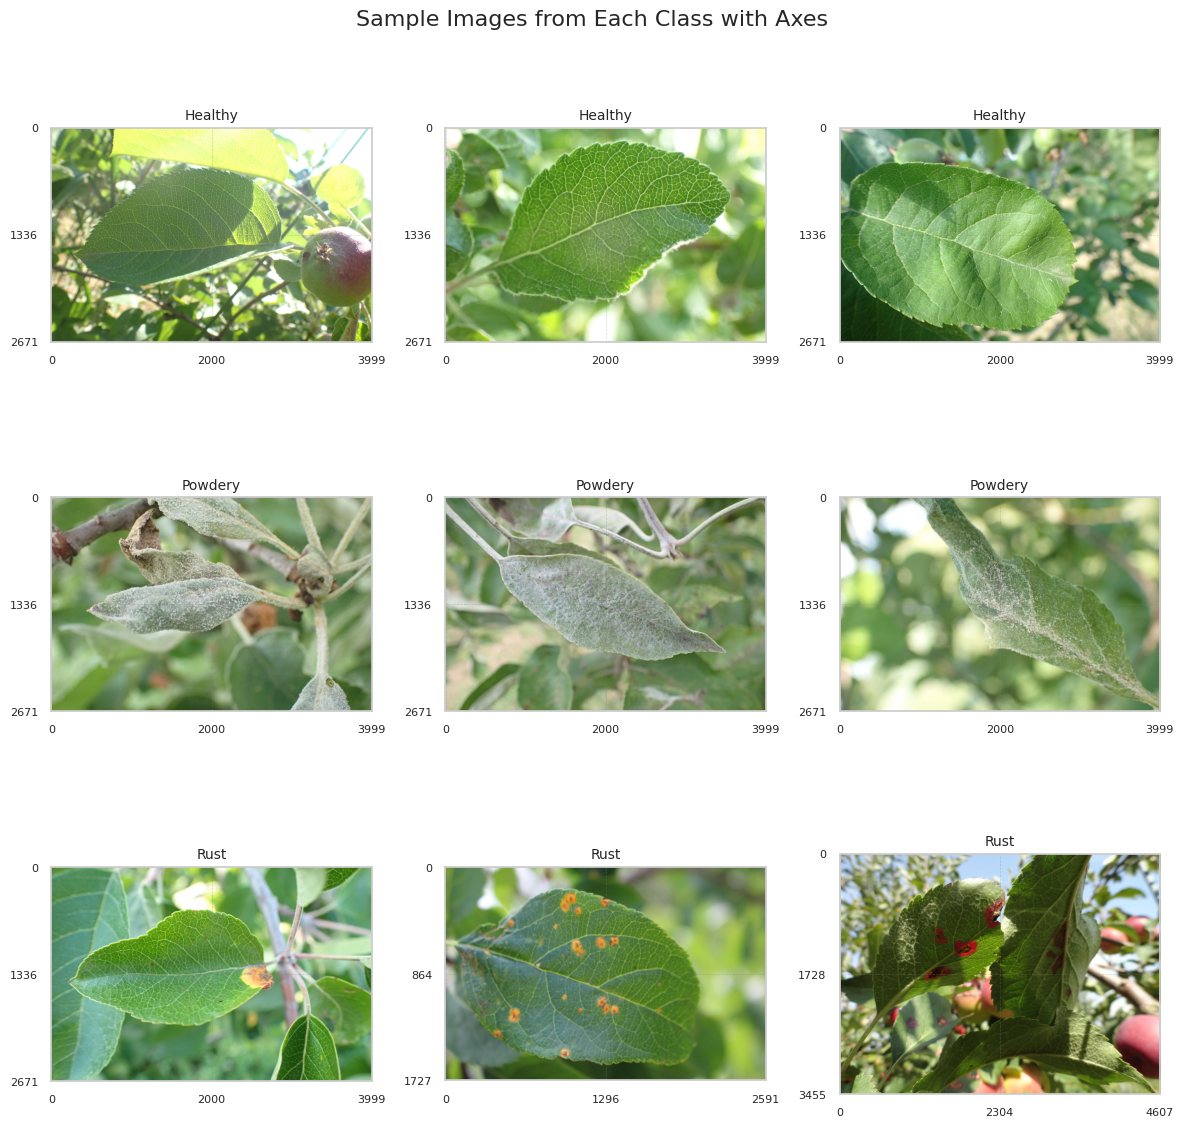

In [10]:
import cv2
import os
import matplotlib.pyplot as plt

def show_sample_images_with_axes(data_path, classes, image_per_class=2):
    fig, axs = plt.subplots(len(classes), image_per_class, figsize=(image_per_class * 4, len(classes) * 4))

    if len(classes) == 1:
        axs = [axs]  # handle when there is only one class
    elif image_per_class == 1:
        axs = [[ax] for ax in axs]  # handle 1 column

    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        images = os.listdir(class_folder)[:image_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            ax = axs[i][j]
            ax.imshow(img)
            ax.set_title(f"{class_name}", fontsize=10)
            ax.set_xticks([0, img.shape[1]//2, img.shape[1]-1])
            ax.set_yticks([0, img.shape[0]//2, img.shape[0]-1])
            ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=8)

    plt.suptitle("Sample Images from Each Class with Axes", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images_with_axes(trainpth, ['Healthy', 'Powdery', 'Rust'], image_per_class=3)

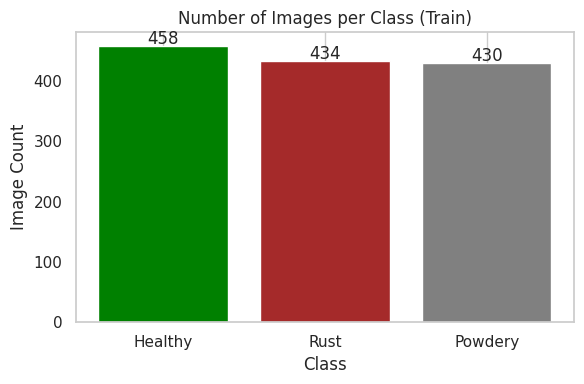

In [11]:
# Visualizing classes imbalances
import os
import matplotlib.pyplot as plt
import numpy as np

class_counts = {}
for class_name in os.listdir(trainpth):
    class_folder = os.path.join(trainpth, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(6,4))
plt.bar(classes, counts, color=['green', 'brown', 'grey'])
plt.title('Number of Images per Class (Train)')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.grid(axis='y')

for i in range(len(classes)):
    plt.text(i, counts[i] + 3, str(counts[i]), ha='center')

plt.tight_layout()
plt.show()

In [12]:
x_train_origin, y_train = loadingData(trainpth)
x_val_origin, y_val = loadingData(valpth)
x_test_origin, y_test = loadingData(testpth)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [13]:
num_classes = len(np.unique(y_train_encoded))
print(f"{num_classes} unique classes in data.")

3 unique classes in data.


In [14]:
print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes mapping: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


In [15]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

def DataGenerator(model='CNN'):
    if model == 'VGG':
        preprocessing = vgg_preprocess
        rescale = None
    elif model == 'ResNet50':
        preprocessing = resnet_preprocess
        rescale = None
    else:
        raise ValueError("Invalid model name")

    datagen = ImageDataGenerator(
        rotation_range=20,
        validation_split=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=rescale,
        preprocessing_function=preprocessing
    )

    return datagen

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Define your model
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757963608.539936      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757963608.540588      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
from tensorflow.keras.optimizers import Adam
model_CNN.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_cnn_train = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = datagen_cnn_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)
datagen_cnn_val = ImageDataGenerator(rescale=1.0 / 255.0)
val_generator = datagen_cnn_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [20]:
history = model_CNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757963802.331861     105 service.cc:148] XLA service 0x79a9ac0020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757963802.332735     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757963802.332761     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757963802.821855     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/21 ━━━━━━━━━━━━━━━━━━━━ 4:44 14s/step - accuracy: 0.3594 - loss: 2.0610

I0000 00:00:1757963812.183645     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 590ms/step - accuracy: 0.6403 - loss: 7.1903 - val_accuracy: 0.3333 - val_loss: 9.7118
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8884 - loss: 1.3967 - val_accuracy: 0.4167 - val_loss: 6.9918
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9175 - loss: 0.8306 - val_accuracy: 0.3833 - val_loss: 13.7164
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9462 - loss: 0.6535 - val_accuracy: 0.4667 - val_loss: 11.8695
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9557 - loss: 0.2836 - val_accuracy: 0.4167 - val_loss: 13.0017
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9620 - loss: 0.1954 - val_accuracy: 0.4500 - val_loss: 12.9461
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9747 - loss: 0.1054 - val_accuracy: 0.5000 - val_loss: 17.1480
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9749 - loss: 0.1428 - val_accuracy: 0.3333 

In [21]:
model_CNN.save('best_cnn_model.h5')

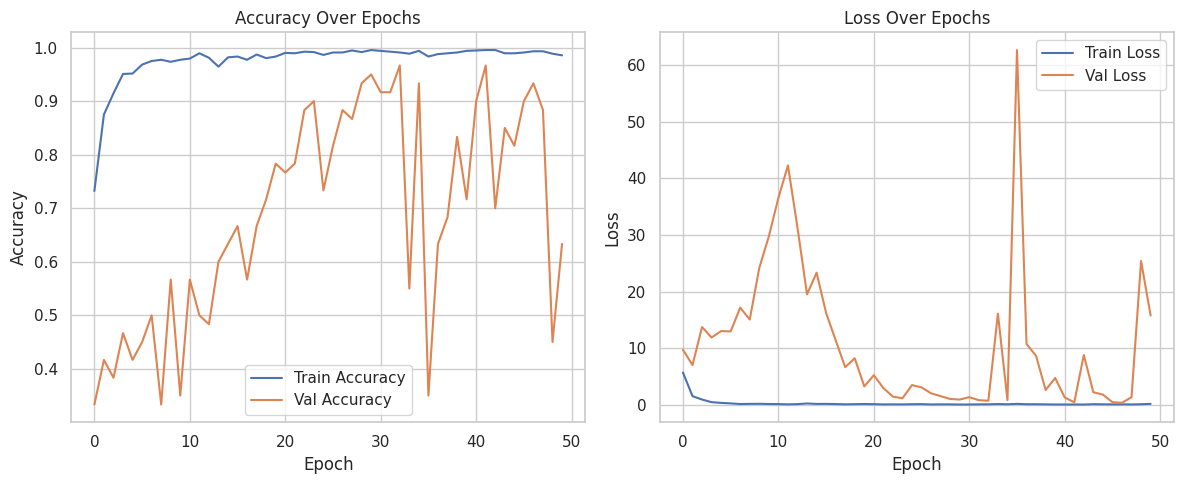

In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [23]:
datagen_CNN_test = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator_CNN = datagen_CNN_test.flow(x_test_origin, y_test_encoded, batch_size=64, shuffle=False)

# Predict
y_pred_probs_CNN = model_CNN.predict(test_generator_CNN)
y_pred_CNN = np.argmax(y_pred_probs_CNN, axis=1)
y_true = y_test_encoded

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step


In [24]:
model_CNN.evaluate(test_generator_CNN)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.8686 - loss: 1.5523


[1.798305630683899, 0.846666693687439]

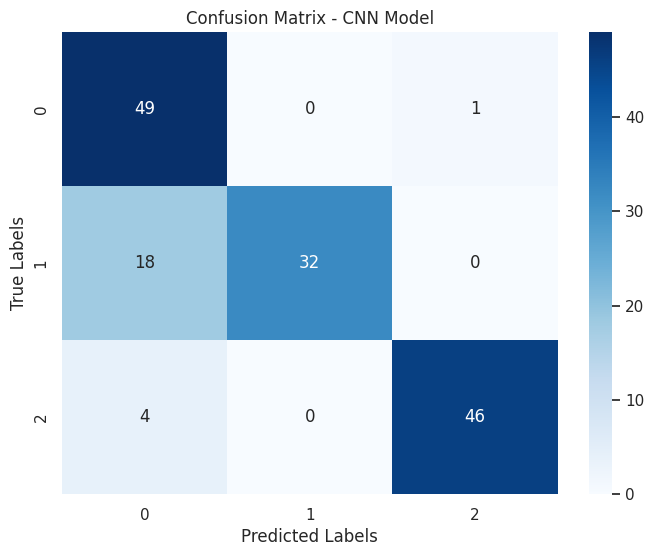

              precision    recall  f1-score   support

     class_0       0.69      0.98      0.81        50
     class_1       1.00      0.64      0.78        50
     class_2       0.98      0.92      0.95        50

    accuracy                           0.85       150
   macro avg       0.89      0.85      0.85       150
weighted avg       0.89      0.85      0.85       150



In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_CNN)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
class_names = ['class_0', 'class_1', 'class_2']
report = classification_report(y_true, y_pred_CNN, target_names=class_names)
print(report)

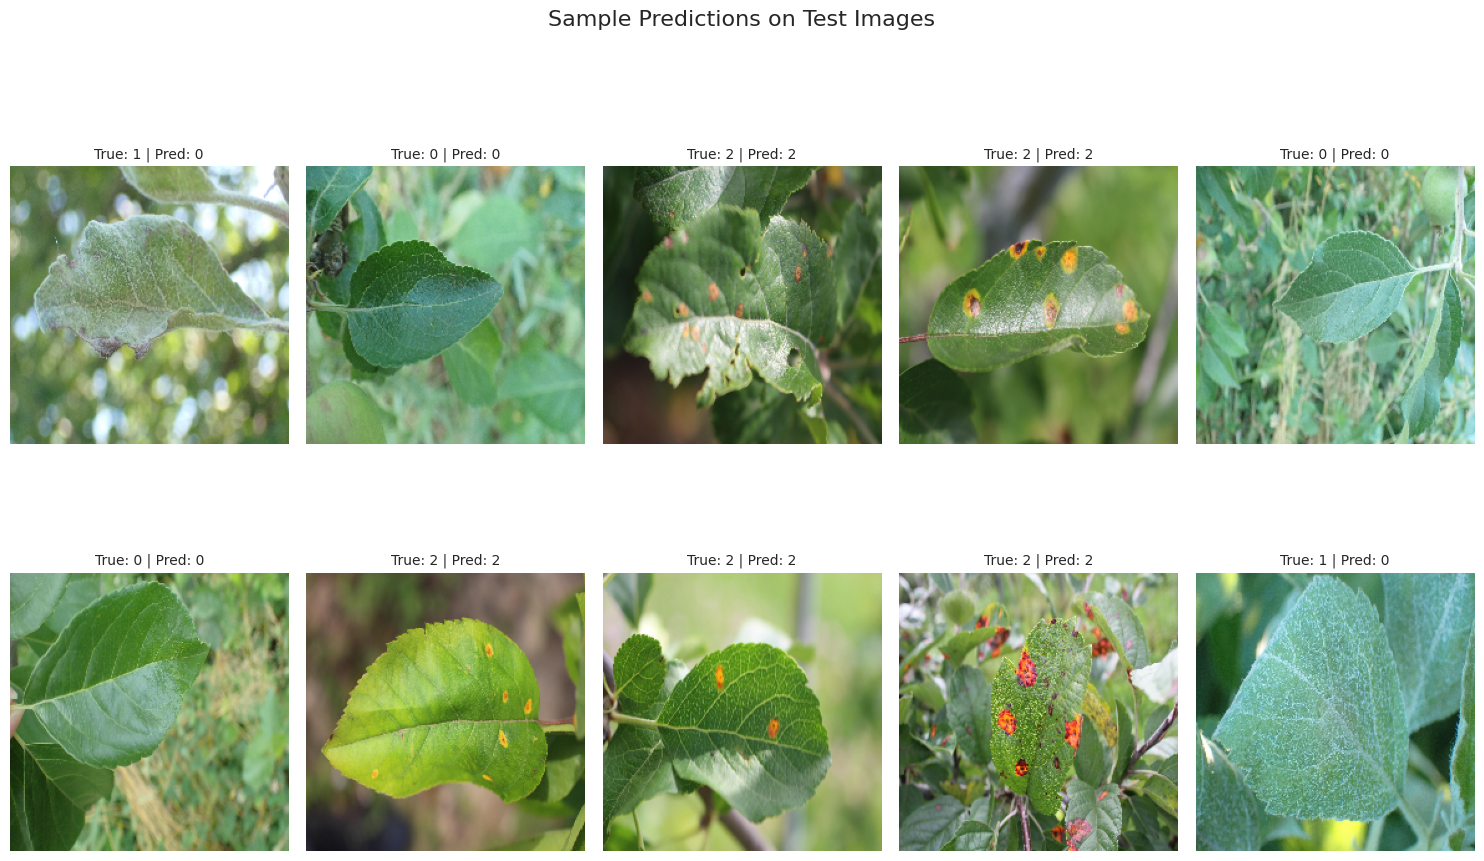

In [26]:
num_samples = 10

indices = np.random.choice(len(x_test_origin), num_samples, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img = x_test_origin[idx]
    true_label = y_test_encoded[idx]
    pred_label = y_pred_CNN[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    true_name = le.inverse_transform([true_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]
    plt.title(f"True: {true_name} | Pred: {pred_name}", fontsize=10)
    plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=10)

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()

In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:10]:
    layer.trainable = False

for layer in base_model.layers[10:]:
    layer.trainable = True
model_VGG = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
model_VGG.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
callbacky =[
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

In [32]:
datagen_vgg_train = DataGenerator(model='VGG')
train_generator_vgg = datagen_vgg_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)

datagen_vgg_val = DataGenerator(model='VGG')
val_generator_vgg = datagen_vgg_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [33]:
history = model_VGG.fit(
  train_generator_vgg,
  validation_data=val_generator_vgg,
  epochs=30,
  batch_size=64
  )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-09-15 19:24:29.955557: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-15 19:24:30.161340: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.20588757s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFo

21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.4418 - loss: 1.3129 - val_accuracy: 0.3333 - val_loss: 172.6091
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 691ms/step - accuracy: 0.4787 - loss: 1.0643 - val_accuracy: 0.3333 - val_loss: 7.9200
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 700ms/step - accuracy: 0.6237 - loss: 0.8082 - val_accuracy: 0.7167 - val_loss: 0.5165
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 712ms/step - accuracy: 0.7176 - loss: 0.6407 - val_accuracy: 0.7333 - val_loss: 0.4563
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 673ms/step - accuracy: 0.7974 - loss: 0.5044 - val_accuracy: 0.3000 - val_loss: 5.1008
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 667ms/step - accuracy: 0.8387 - loss: 0.4544 - val_accuracy: 0.3333 - val_loss: 4083.4280
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - accuracy: 0.8824 - loss: 0.3922 - val_accuracy: 0.4167 - val_loss: 1.6694
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 708ms/step - accuracy: 0.8953 - loss: 0.3572 - val_accuracy: 0.3

In [34]:
import numpy as np

# Save history for later use
np.save('vgg_history.npy', history.history)

In [35]:
model_VGG.save('vgg_model_full.h5')

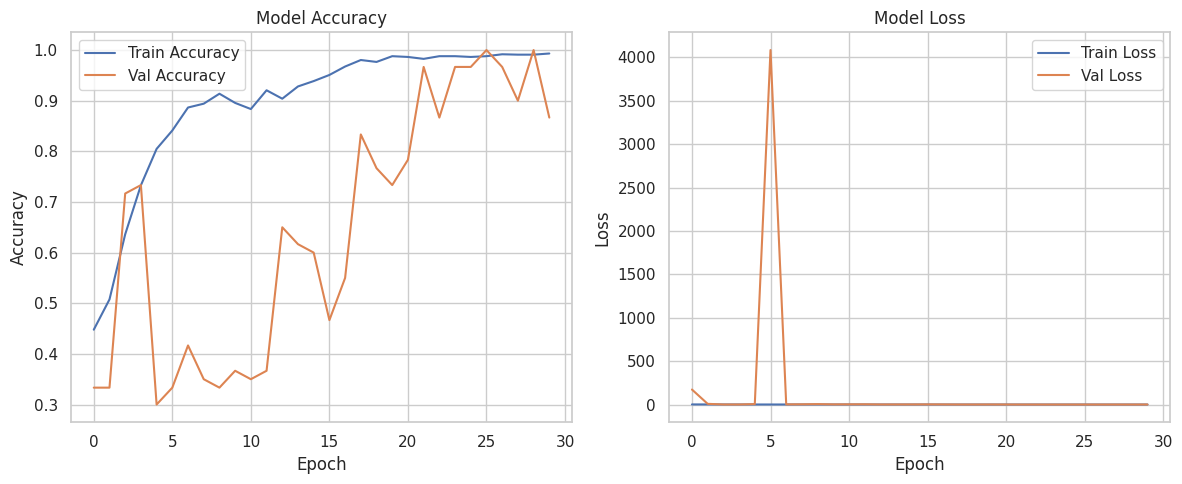

In [36]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
